## Trying KNN text classification from ICLR 2013 reviews

Using ICLR reviews from openreview, KNN was used in this notebook, using the decision as label for a review

In [23]:
import pandas as pd
import ast # Library to parse code, since replies were saved as a list format in the csv
from collections import Counter
import random
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from matplotlib import pyplot as plt
import string
import re
import numpy as np
from collections import Counter

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/eisen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eisen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
path_to_data = "iclr_urls.csv"
iclr_conf_data = pd.read_csv(path_to_data) 
iclr_conf_data.head()

,conference,conference_url,n_papers,comments
0,iclr2013_conference,ICLR.cc/2013/conference/-/submission,67,NaN
1,iclr2014_conference,ICLR.cc/2014/conference/-/submission,69,without decisions data
2,iclr2014_workshop,ICLR.cc/2014/workshop/-/submission,19,without decision data
3,iclr2016_workshop,ICLR.cc/2016/workshop/-/submission,125,without decision data
4,iclr2017_conference,ICLR.cc/2017/conference/-/paper.*/acceptance,490,NaN


In [3]:
csv_names = list(iclr_conf_data['conference'])

#### Using ICLR 2013 data

In [4]:
iclr13_dataset = pd.read_csv(csv_names[0]+".csv")
iclr13_dataset.head()

,title,authors,emails,decision,abstract,pdf,replies
0,Latent Relation Representations for Universal ...,"['Sebastian Riedel', 'Limin Yao', 'Andrew McCa...","['sebastian.riedel@gmail.com', 'isabel0913@gma...",conferencePoster-iclr2013-workshop,Traditional relation extraction predicts relat...,https://arxiv.org/abs/1301.4293,"[[('title', ''), ('review', 'This is a test of..."
1,Sparse Penalty in Deep Belief Networks: Using ...,"['Xanadu Halkias', 'Sébastien PARIS', 'Herve G...","['xch1@caa.columbia.edu', 'sebastien.paris@lsi...",reject,Deep Belief Networks (DBN) have been successfu...,https://arxiv.org/abs/1301.3533,"[[('title', 'review of Sparse Penalty in Deep ..."
2,Why Size Matters: Feature Coding as Nystrom Sa...,"['Oriol Vinyals', 'Yangqing Jia', 'Trevor Darr...","['oriol18@gmail.com', 'jiayq84@gmail.com', 'tr...",conferenceOral-iclr2013-workshop,"Recently, the computer vision and machine lear...",https://arxiv.org/abs/1301.5348,"[[('title', ''), ('review', ""We agree with the..."
3,Joint Space Neural Probabilistic Language Mode...,['Tsuyoshi Okita'],['tsuyoshi.okita2@mail.dcu.ie'],reject,A neural probabilistic language model (NPLM) p...,https://arxiv.org/abs/1301.3614,"[[('title', 'review of Joint Space Neural Prob..."
4,Unsupervised Feature Learning for low-level Lo...,"['Christian Osendorfer', 'Justin Bayer', 'Patr...","['osendorf@gmail.com', 'bayer.justin@googlemai...",conferencePoster-iclr2013-workshop,Unsupervised feature learning has shown impres...,https://arxiv.org/abs/1301.2840,"[[('title', ''), ('reply', ""Deare954,\r\nthank..."


In [5]:
replies = iclr13_dataset['replies']
print("Number of papers: " + str(len(replies))) 
replies[:5]

Number of papers: 67


0    [[('title', ''), ('review', 'This is a test of...
1    [[('title', 'review of Sparse Penalty in Deep ...
2    [[('title', ''), ('review', "We agree with the...
3    [[('title', 'review of Joint Space Neural Prob...
4    [[('title', ''), ('reply', "Deare954,\r\nthank...
Name: replies, dtype: object

In [6]:
decision_options = Counter(iclr13_dataset['decision'])
decision_options

Counter({'conferencePoster-iclr2013-workshop': 25,
         'reject': 12,
         'conferenceOral-iclr2013-workshop': 7,
         'conferencePoster-iclr2013-conference': 9,
         'conferenceOral-iclr2013-conference': 14})

In [16]:
decision_labels = {'conferencePoster-iclr2013-workshop': 0, \
                   "reject": 1, \
                   "conferenceOral-iclr2013-workshop": 2, \
                   "conferencePoster-iclr2013-conference": 3, \
                   "conferenceOral-iclr2013-conference": 4}
decision_labels

{'conferencePoster-iclr2013-workshop': 0,
 'reject': 1,
 'conferenceOral-iclr2013-workshop': 2,
 'conferencePoster-iclr2013-conference': 3,
 'conferenceOral-iclr2013-conference': 4}

In [17]:
def match_reviews_and_decision(df_venue, labels):
  """Creates and lists of lists containing a review an its decision
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    labels (dictionary): Maps a string to a number that encodes the decision as an integer
  Returns:
    A lists of pairs where the first elements are the decision encoded with the labels
    and the second elements is the review.
    
  """

  decision_review = []
  for index, row in df_venue.iterrows():
    comments = ast.literal_eval(row['replies'])
    for comment in comments:
      if comment[1][0] == "review": # filtering comments that are reviews only
        decision_review.append([labels[row['decision']],comment[1][1]])
  return decision_review

In [19]:
decision_review = match_reviews_and_decision(iclr13_dataset, decision_labels)
len(decision_review)

309

#### Defining cleaning method includes punctuation marks, stop words & digits.

In [12]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    processed = re.sub(r"\d+","",normalized)
    y = processed.split()
    return y

In [20]:
def preprocess_data(df_venue):
  """Does the preprocessing applying the clean function and the
  TfidVectorizer using the english stopwords
  
  Args:
    df_venue (pandas dataframe): Contains data from a venue where each row represents
    a paper that have title, authors, emails, decision, abstract, pdf and replies fields.
    
  Returns:
    X (sparse matrix, [n_samples, n_features]): Tf-idf-weighted document-term matrix.
    y (lists of integers): labels encoded as integers.

  """

  train_clean_sentences = []
  y = np.array([y[0] for y in decision_review])

  for line in decision_review:
    line = line[1].strip()
    cleaned = clean(line)
    cleaned = ' '.join(cleaned)
    train_clean_sentences.append(cleaned)
    
  vectorizer = TfidfVectorizer(stop_words='english')
  X = vectorizer.fit_transform(train_clean_sentences)
  
  return X, y

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    y_true = [int(x) for x in y_true]
    y_pred = [int(x) for x in y_pred]
    
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [22]:
X, y = preprocess_data(decision_review)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


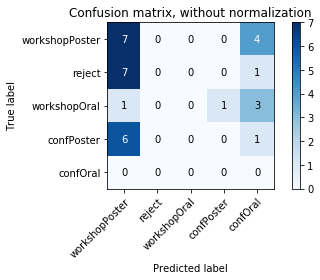

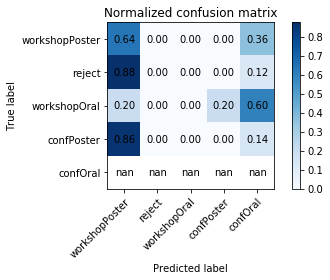

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


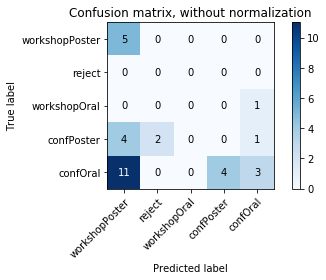

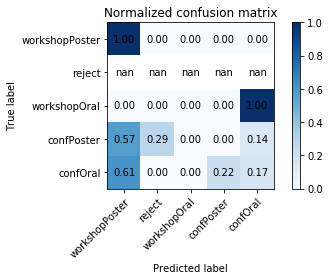

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


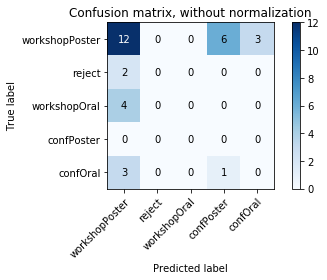

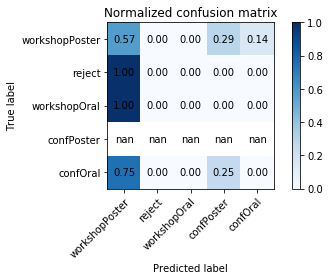

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


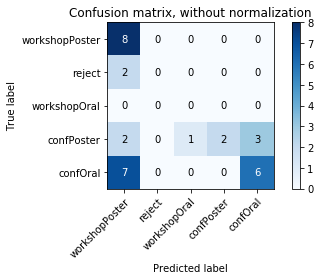

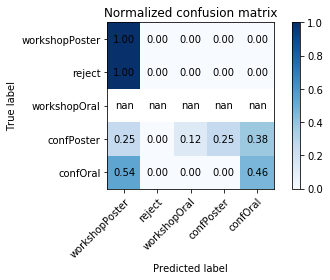

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


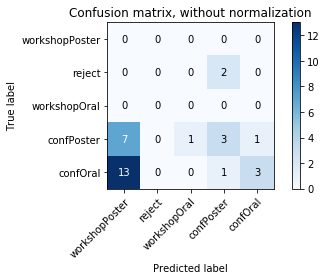

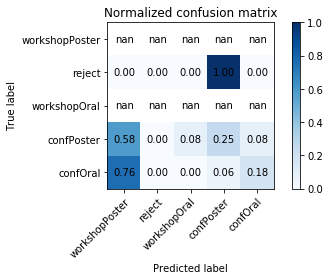

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


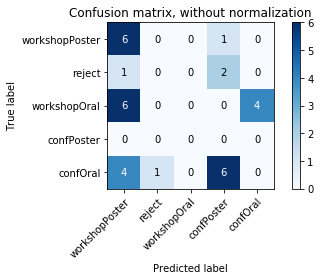

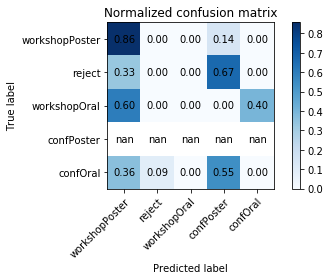

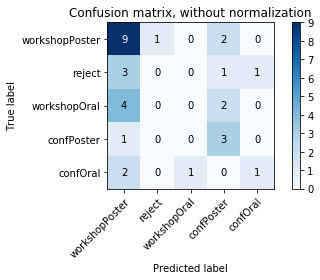

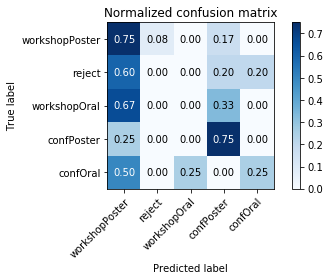

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


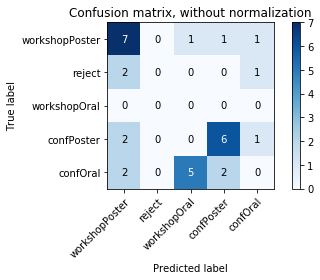

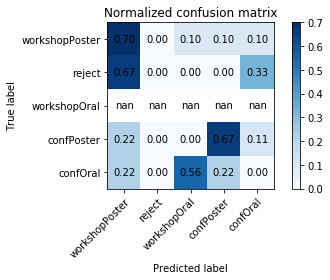

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


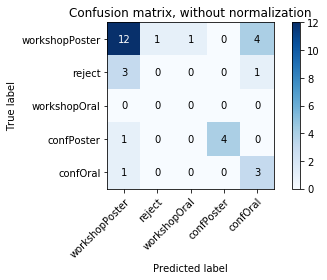

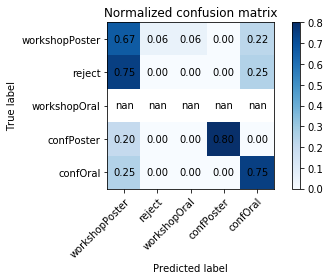

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


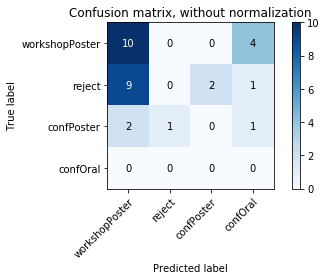

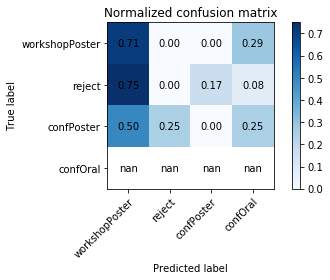

In [31]:
modelknn = KNeighborsClassifier(n_neighbors=4)

scores = []
cv = KFold(n_splits=10, random_state=420, shuffle=False)
class_names = np.array(["workshopPoster","reject", "workshopOral", "confPoster","confOral"])

for train_index, test_index in cv.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  modelknn.fit(X_train,y_train)
  scores.append(modelknn.score(X_test, y_test))    
  np.set_printoptions(precision=2)
  y_pred = modelknn.fit(X_train, y_train).predict(X_test)
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, title="Confusion matrix, without normalization")
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title="Normalized confusion matrix")
  plt.show()

In [33]:
scores

[0.22580645161290322,
 0.25806451612903225,
 0.3870967741935484,
 0.5161290322580645,
 0.1935483870967742,
 0.1935483870967742,
 0.41935483870967744,
 0.41935483870967744,
 0.6129032258064516,
 0.3333333333333333]

In [34]:
# Perform 10-fold cross validation
scores = cross_val_score(modelknn, X, y, cv=10)
print("Cross-validated scores:", scores)
print("Avg score: ", sum(scores)/len(scores))

Cross-validated scores: [0.27 0.5  0.38 0.56 0.53 0.5  0.41 0.59 0.41 0.34]
Avg score:  0.4500097962382445
